In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from numba import jit
from tqdm.notebook import tqdm

In [26]:
@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

In [27]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta
def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [28]:

@jit(nopython = True)
def RKHG(f,y0,t,D,args=()):
    n = len(t)
    size = len(y0)
    y = np.zeros((n, size))
    y[0] = y0
    h = t[1] - t[0]
    sh = np.sqrt(h)
    for i in range(n - 1):
        S = np.random.choice(np.array([-1,1]),size=size)
        dW = np.random.normal(0,1,size)*sh
        k1 = h*f(y[i],t[i],*args) + (dW - S*sh)*D
        k2 = h*f(y[i]+k1,t[i]+h,*args) + (dW + S*sh)*D
        y[i+1] = y[i] + 0.5*(k1+k2)
    return y

@jit(nopython = True)
def Kuramoto_AR(Theta,t,omega,N,K,mk,Aij,b):
    # print("Case m = 0")
    Theta = Theta.copy()
    theta = Theta[:N]
    theta_i= theta.reshape(1,-1)
    theta_j = theta_i.T
    # theta_i,theta_j = np.meshgrid(theta,theta,sparse=True)
    dtheta = omega +  K/mk*np.sum(Aij*np.sin(theta_j - theta_i),axis=0)  - b*np.sin(theta)
    Theta[:N] = dtheta
    return Theta

In [4]:
theta_i,theta_j = np.meshgrid(theta_random,theta_random,sparse=True)


NameError: name 'theta_random' is not defined

In [44]:
theta_i.shape, theta_j.shape

((1, 1000), (1000, 1))

In [29]:
N = 1000

theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

In [30]:
mk = 5
p = mk/(N)
G = nx.erdos_renyi_graph(N,p)
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
MD = Deg.mean()

In [46]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.51
%timeit sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

17.4 s ± 656 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

20.4 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
db = 0.05
Ds = np.arange(0,1.5+db/2,db)
bs = np.arange(0,1.5+db/2,db)
len(Ds)

31

In [17]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for b in bs:        
        sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
        theta_s = sol[th:,:N]
        dtheta_s = sol[th:,N:2*N] 
        rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
        # rabs = rabs_[len(t)//2:]
        r = np.abs(rabs)
        sigma_phi = np.mean(rabs)
        sigma = np.abs(sigma_phi)
        psi = np.abs(sigma_phi)
        sigma,np.mean(r)
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/31 [00:00<?, ?it/s]

In [20]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
D_r_meanij = np.mean(D_rij,axis=2)

In [19]:
np.savez(f'mk = {mk} db={db}',Ds=Ds,bs=bs,D_rij =D_rij,D_mrij=D_r_meanij,D_sij = D_sigmaij,G = G)

In [50]:
DD,BB = np.meshgrid(Ds*2,bs)

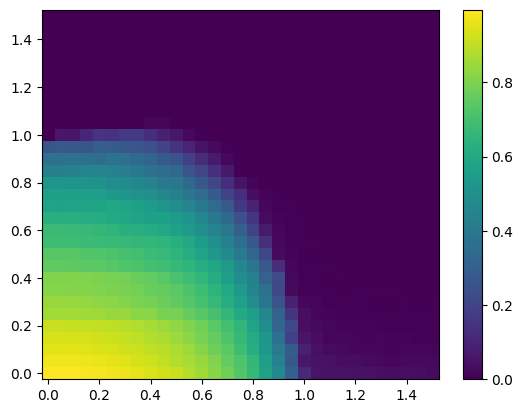

In [22]:
Z = np.abs(D_sigmaij-D_r_meanij).T
# CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

CS  = plt.pcolormesh(Ds,bs,abs(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


In [15]:
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,20, cmap=plt.cm.bone)

# CS  = plt.pcolormesh(Ds,bs,(D_sigmaij-D_r_meanij).T)
# CS2 = plt.contour(CS, levels=CS.levels[::2], colors='r')
cbar = plt.colorbar(CS)
# cbar.add_lines(CS2)

# plt.contourf((D_sigmaij-D_r_meanij).T,extent=[0,2,0,2])
# plt.imshow(D_sigmaij.T)
# plt.axes().set_aspect('equal')
# plt.pcolormesh(Ds,bs,D_sigmaij.T)


NameError: name 'DD' is not defined

In [45]:
DIJ_ER = np.load('mk = 5 db=0.05.npz')
print(*DIJ_ER.keys())
D_ER_r_meanij = DIJ_ER['D_mrij'][:31,:31]
D_ER_sigmaij = DIJ_ER['D_sij'][:31,:31]
bs_ER = DIJ_ER['bs'][:31]
Ds_ER = DIJ_ER['Ds'][:31]*2

Ds bs D_rij D_mrij D_sij G


In [46]:
DIJ = np.load('m = 10 mk = 19.8 db=0.1 SF.npz')
print(*DIJ.keys())
D_r_meanij = DIJ['D_mrij']
D_sigmaij = DIJ['D_sij']
bs_SF= DIJ['bs']
Ds_SF= DIJ['Ds']*2

Ds bs D_mrij D_sij G


In [47]:
DIJ2 = np.load('db=0.05.npz')
print(*DIJ2.keys())
D_MF_r_meanij = DIJ2['D_mrij'][:31,:31]
D_MF_sigmaij = DIJ2['D_sij'][:31,:31]
bs_MF= DIJ2['bs'][:31]
Ds_MF= DIJ2['Ds'][:31]*2

Ds bs D_rij D_mrij D_sij


In [119]:
import glob

In [128]:
idx = glob.glob('m = 3** db=0.1 SF.npz')
idx

['m = 3 mk = 5.982 db=0.1 SF.npz']

In [ ]:
DIJ = np.load('m = 10 mk = 19.8 db=0.1 SF.npz')
print(*DIJ.keys())
D_r_meanij = DIJ['D_mrij']
D_sigmaij = DIJ['D_sij']
bs_SF= DIJ['bs']
Ds_SF= DIJ['Ds']*2

In [114]:


DIJ_WS = np.load('WS,mk = 10.0 db=0.1 SF.npz')
print(*DIJ_WS.keys())
D_WS_r_meanij = DIJ_WS['D_mrij']
D_WS_sigmaij = DIJ_WS['D_sij']
bs_WS= DIJ_WS['bs']
Ds_WS= DIJ_WS['Ds']*2

Ds bs D_mrij D_sij G


In [107]:
DD_MF, BB_MF = np.meshgrid(Ds_MF,bs_MF)

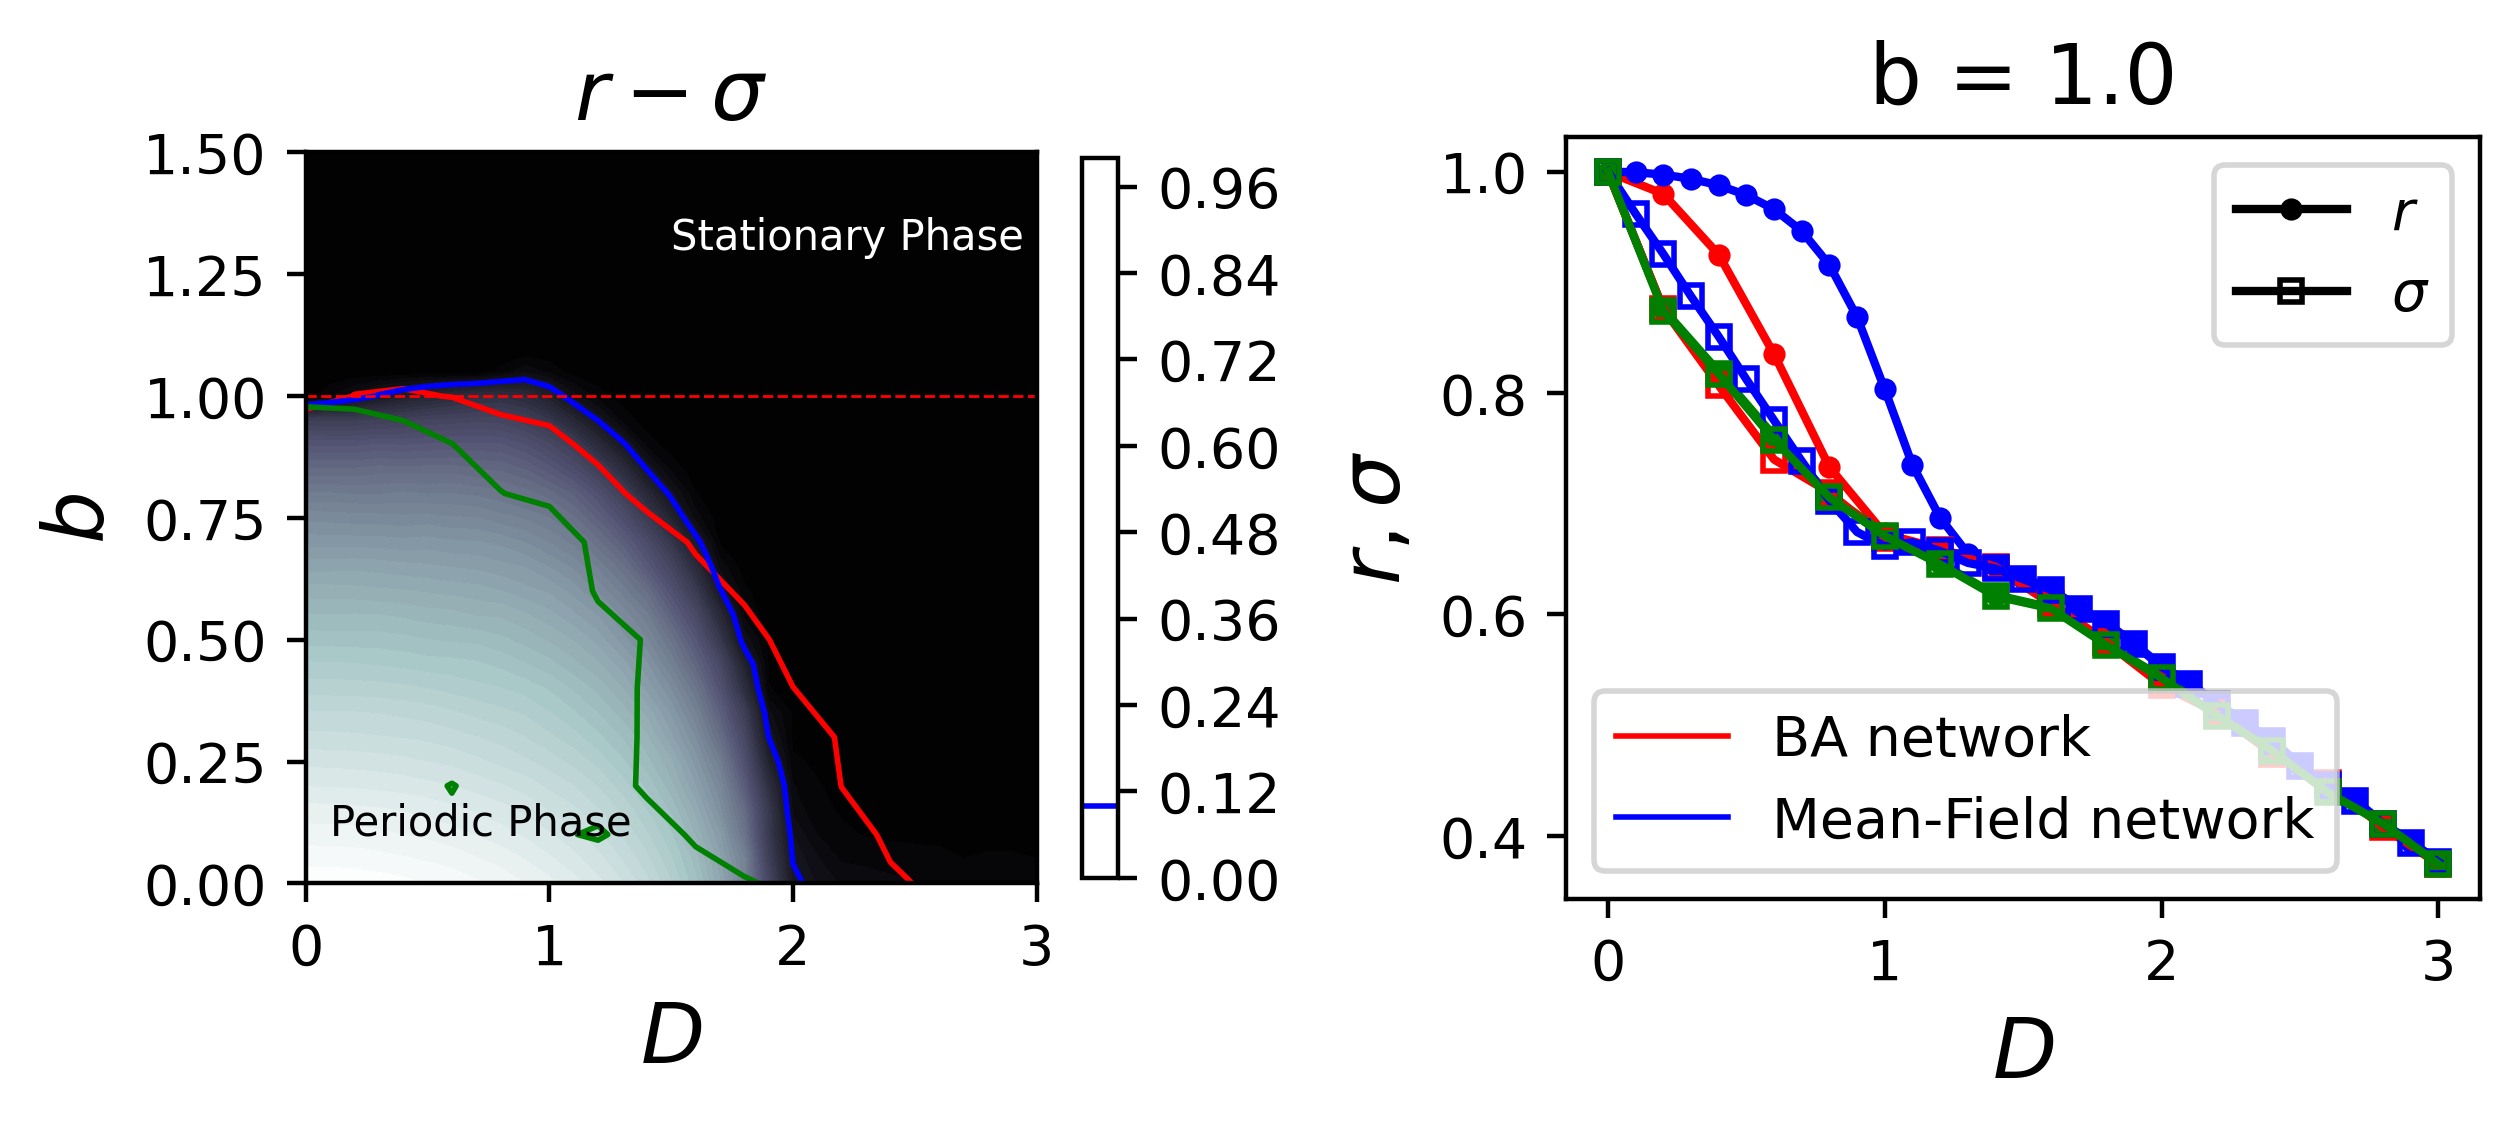

In [129]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 10
Z_MF = np.abs(D_MF_sigmaij-D_MF_r_meanij).T
# Z_ER = np.abs(D_ER_sigmaij-D_ER_r_meanij).T
Z_WS = np.abs(D_WS_sigmaij-D_WS_r_meanij).T
for name in idx[:]:
    DIJ = np.load(name)
    # print(*DIJ.keys())
    D_r_meanij = DIJ['D_mrij']
    D_sigmaij = DIJ['D_sij']
    bs_SF= DIJ['bs']
    Ds_SF= DIJ['Ds']*2
    Z = np.abs(D_sigmaij-D_r_meanij).T
    CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone,alpha=0)
    CS2 = plt.contour(CS, levels=CS.levels[5:6],linewidths=1, colors='r')
CS_MF = plt.contourf(DD_MF, BB_MF, Z_MF,50, cmap=plt.cm.bone,alpha=1.0)
CS_WS = plt.contourf(DD, BB, Z_WS,50, cmap=plt.cm.bone,alpha=0)
# CS_ER = plt.contourf(DD_MF, BB_MF, Z_ER,50, cmap=plt.cm.bone,alpha=0.0)
CS2_MF = plt.contour(CS_MF, levels=CS_MF.levels[5:6],linewidths=1, colors='b')
CS2_WS = plt.contour(CS_WS, levels=CS_WS.levels[5:6],linewidths=1, colors='g')
# CS2_Er = plt.contour(CS_ER, levels=CS_ER.levels[5:6],linewidths=1, colors='g')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('2')
cbar.add_lines(CS2)
cbar.add_lines(CS2_MF)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)
plt.text(0.1,0.1,'Periodic Phase',fontsize=7.5)
plt.text(1.5,1.3,'Stationary Phase',fontsize=7.5,color='white')
plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)
r_marker, = plt.plot(np.nan,np.nan,'.-',color='black',label =r'$r$')
sigma_marker, = plt.plot(np.nan,np.nan,'s-',color='black',markersize=4,label =r'$\sigma$',fillstyle='none')
SF_l, = plt.plot(np.nan,np.nan,'-',color='red',lw=1)
MF_l, = plt.plot(np.nan,np.nan,'-',color='blue',lw=1)
leg = plt.gca().legend([SF_l,MF_l],['BA network','Mean-Field network'],loc=3)
plt.gca().add_artist(leg)
plt.legend([r_marker,sigma_marker],[r'$r$',r'$\sigma$'])

plt.plot(Ds*2,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds_MF,D_MF_r_meanij[:,b_idx*2],'.-',color='blue',label =r'$r$')
plt.plot(Ds_WS,D_WS_r_meanij[:,b_idx],'.-',color='green',label =r'$r$')

plt.plot(Ds*2,D_sigmaij[:,b_idx],'s-',color='red',markersize=4,label =r'$\sigma$', fillstyle='none')
plt.plot(Ds_MF,D_MF_sigmaij[:,b_idx*2],'s-',color='blue',markersize=4,label =r'$\sigma$',fillstyle='none')
plt.plot(Ds_WS,D_WS_sigmaij[:,b_idx],'s-',color='green',markersize=4,label =r'$\sigma$',fillstyle='none')
plt.gca().set_aspect('4')

# plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()

In [89]:
DIJ['Ds'][:31]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5])

In [90]:
DD_MF,BB_MF = np.meshgrid(Ds_MF,bs_MF)


# ***parmap***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import parmap
import networkx as nx
import To_sim.for_multi as FM
from tqdm.notebook import tqdm


In [3]:
from scipy.special import erfinv
import scipy.stats as scs

def _make_init_theta_(seed,N):
    if type(seed)==str:
        init_theta= np.linspace(-np.pi,np.pi,N,endpoint=False)
    else:
        np.random.seed(seed)
        init_theta = np.random.uniform(-np.pi, np.pi, size=N)
    return init_theta

def Q_Normal(N, mean=0, sigma=1,seed=None):
    """return theta, omega, Kc"""
    init_theta = _make_init_theta_(seed,N)
    init_omega = np.array([mean +sigma*(2**0.5)*erfinv((2*i - N - 1)/(N+1)) for i in range(1,N+1)])
    Kc = 2 / (np.pi * scs.cauchy.pdf(mean, mean, sigma))
    return init_theta, init_omega, Kc

In [71]:
m = 1
N = 1000
# p = mk/(N)
# G = nx.erdos_renyi_graph(N,p)
# G = nx.barabasi_albert_graph(N,m)
k = int(N*0.01)
p = 0.5
G = nx.watts_strogatz_graph(N,k,p)
# G = nx.barabasi_albert_graph(N,m)
theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=10)
omega = np.sort(omega)-np.mean(omega)
omega = np.ones(N)

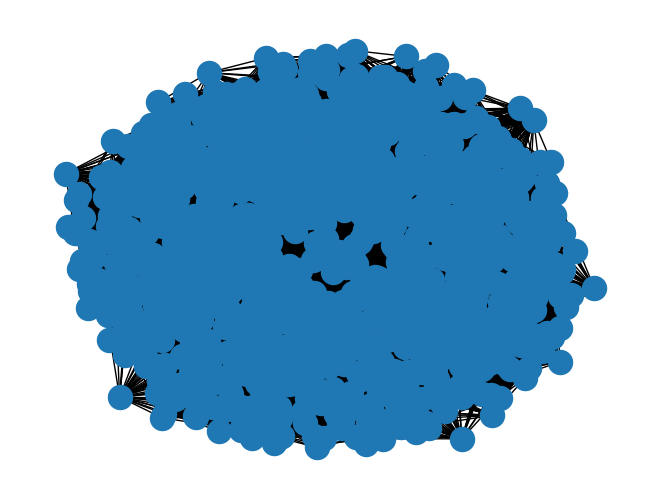

In [21]:
nx.draw(G)

In [30]:
p

0.7

In [26]:
DIJ = np.load('m = 10 mk = 19.8 db=0.1 SF.npz')

In [33]:
print(*DIJ.keys())

Ds bs D_mrij D_sij G


In [102]:
D_r_meanij = DIJ['D_mrij']
D_sigmaij = DIJ['D_sij']

NameError: name 'DIJ' is not defined

In [8]:
A = nx.adjacency_matrix(G)
Aij = A.todense()
Deg = Aij.sum(axis=1)
DegT = Deg.reshape(-1,1)
mk = Deg.mean()
mk

340.0

In [85]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 1
b = 0.5
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
# sol = RKHG(Kuramoto_mf,theta_random,t,D, args=(omega, N, K))
sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega, N, K,b))
th = len(t)//2
theta_s = sol[th:,:N]
dtheta_s = sol[th:,N:2*N] 
rabs = np.mean(np.exp(theta_s.T*1j),axis=0)
# rabs = rabs_[len(t)//2:]
r = np.abs(rabs)
sigma_phi = np.mean(rabs)
sigma = np.abs(sigma_phi)
psi = np.abs(sigma_phi)

In [84]:
np.mean(r) - sigma,sigma

(0.0006554934301079562, 0.6684918760857287)

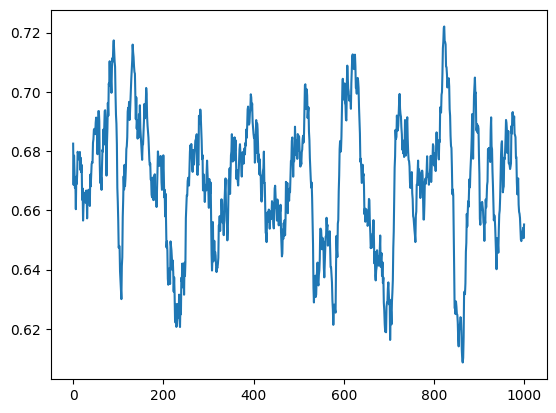

In [83]:
plt.plot(r)

In [24]:
# A = nx.adjacency_matrix(G)
Aij = A.todense()

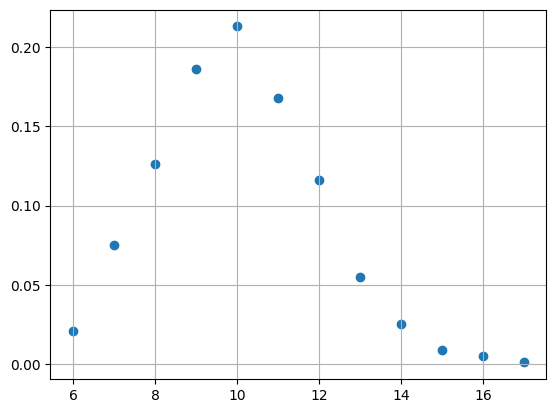

In [72]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
deg,freq = np.unique(degree_sequence, return_counts=True)
density  = freq/np.sum(freq)
# plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.scatter(deg,density)
# plt.loglog()
plt.grid()

In [23]:
K = 1
t_end = 200
dt = 0.1
t = np.arange(0, t_end+dt/2, dt)
D = 0.3
b = 1.0
th = len(t)//2
# sol = RKHG(Kuramoto_AR,theta_random,t,D, args=(omega,N,K,mk,Aij,b))

In [74]:
db = 0.1
Ds = np.arange(0,1.5+db/2,db)
bs = np.arange(0,1.5+db/2,db)
len(Ds)
print(mk)

340.0


In [10]:
th = len(t)//2
D_rij = []
D_sigmaij = []
for D in tqdm(Ds):
    D_rs = []
    D_sigmas = []
    for r,sigma in parmap.map(FM.get_r_sigma,bs,theta_random,t,D,omega,N,K,mk,Aij,pm_processes=12,pm_pbar=True):
        D_rs.append(r)
        D_sigmas.append(sigma)
    D_rij.append(D_rs)
    D_sigmaij.append(D_sigmas)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [11]:
D_rij = np.array(D_rij)
D_sigmaij = np.array(D_sigmaij)
# D_r_meanij = np.mean(D_rij,axis=2)
D_r_meanij = D_rij# np.mean(D_rij,axis=2)

In [18]:
np.savez(f'WS,mk = {mk} db={db} p ={p} SF',Ds=Ds,bs=bs,D_mrij=D_r_meanij,D_sij = D_sigmaij,G = G)

In [15]:
DD,BB = np.meshgrid(Ds,bs)

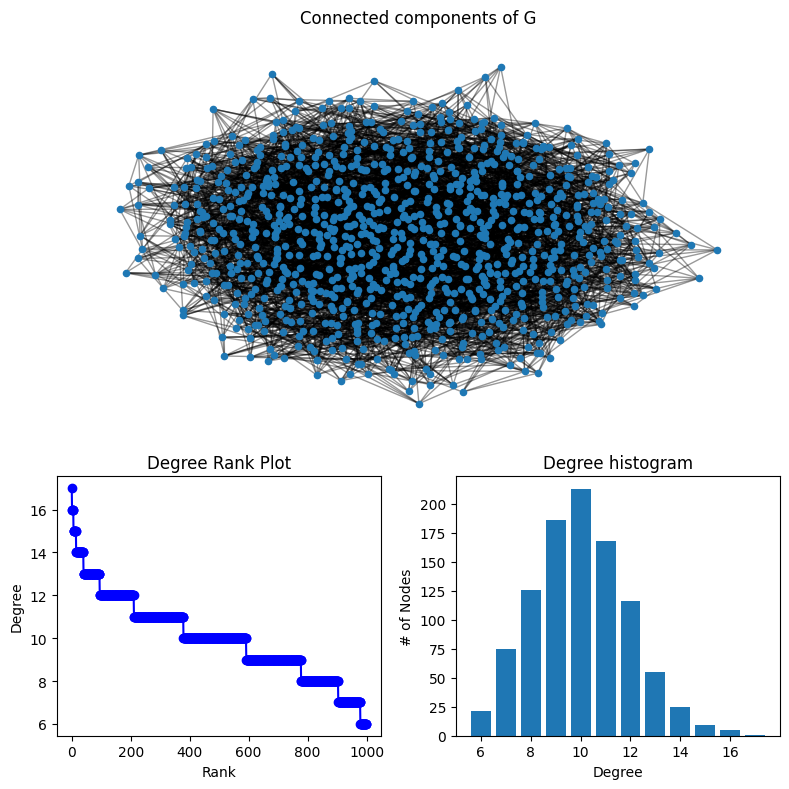

In [73]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# G = nx.gnp_random_graph(N, p, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

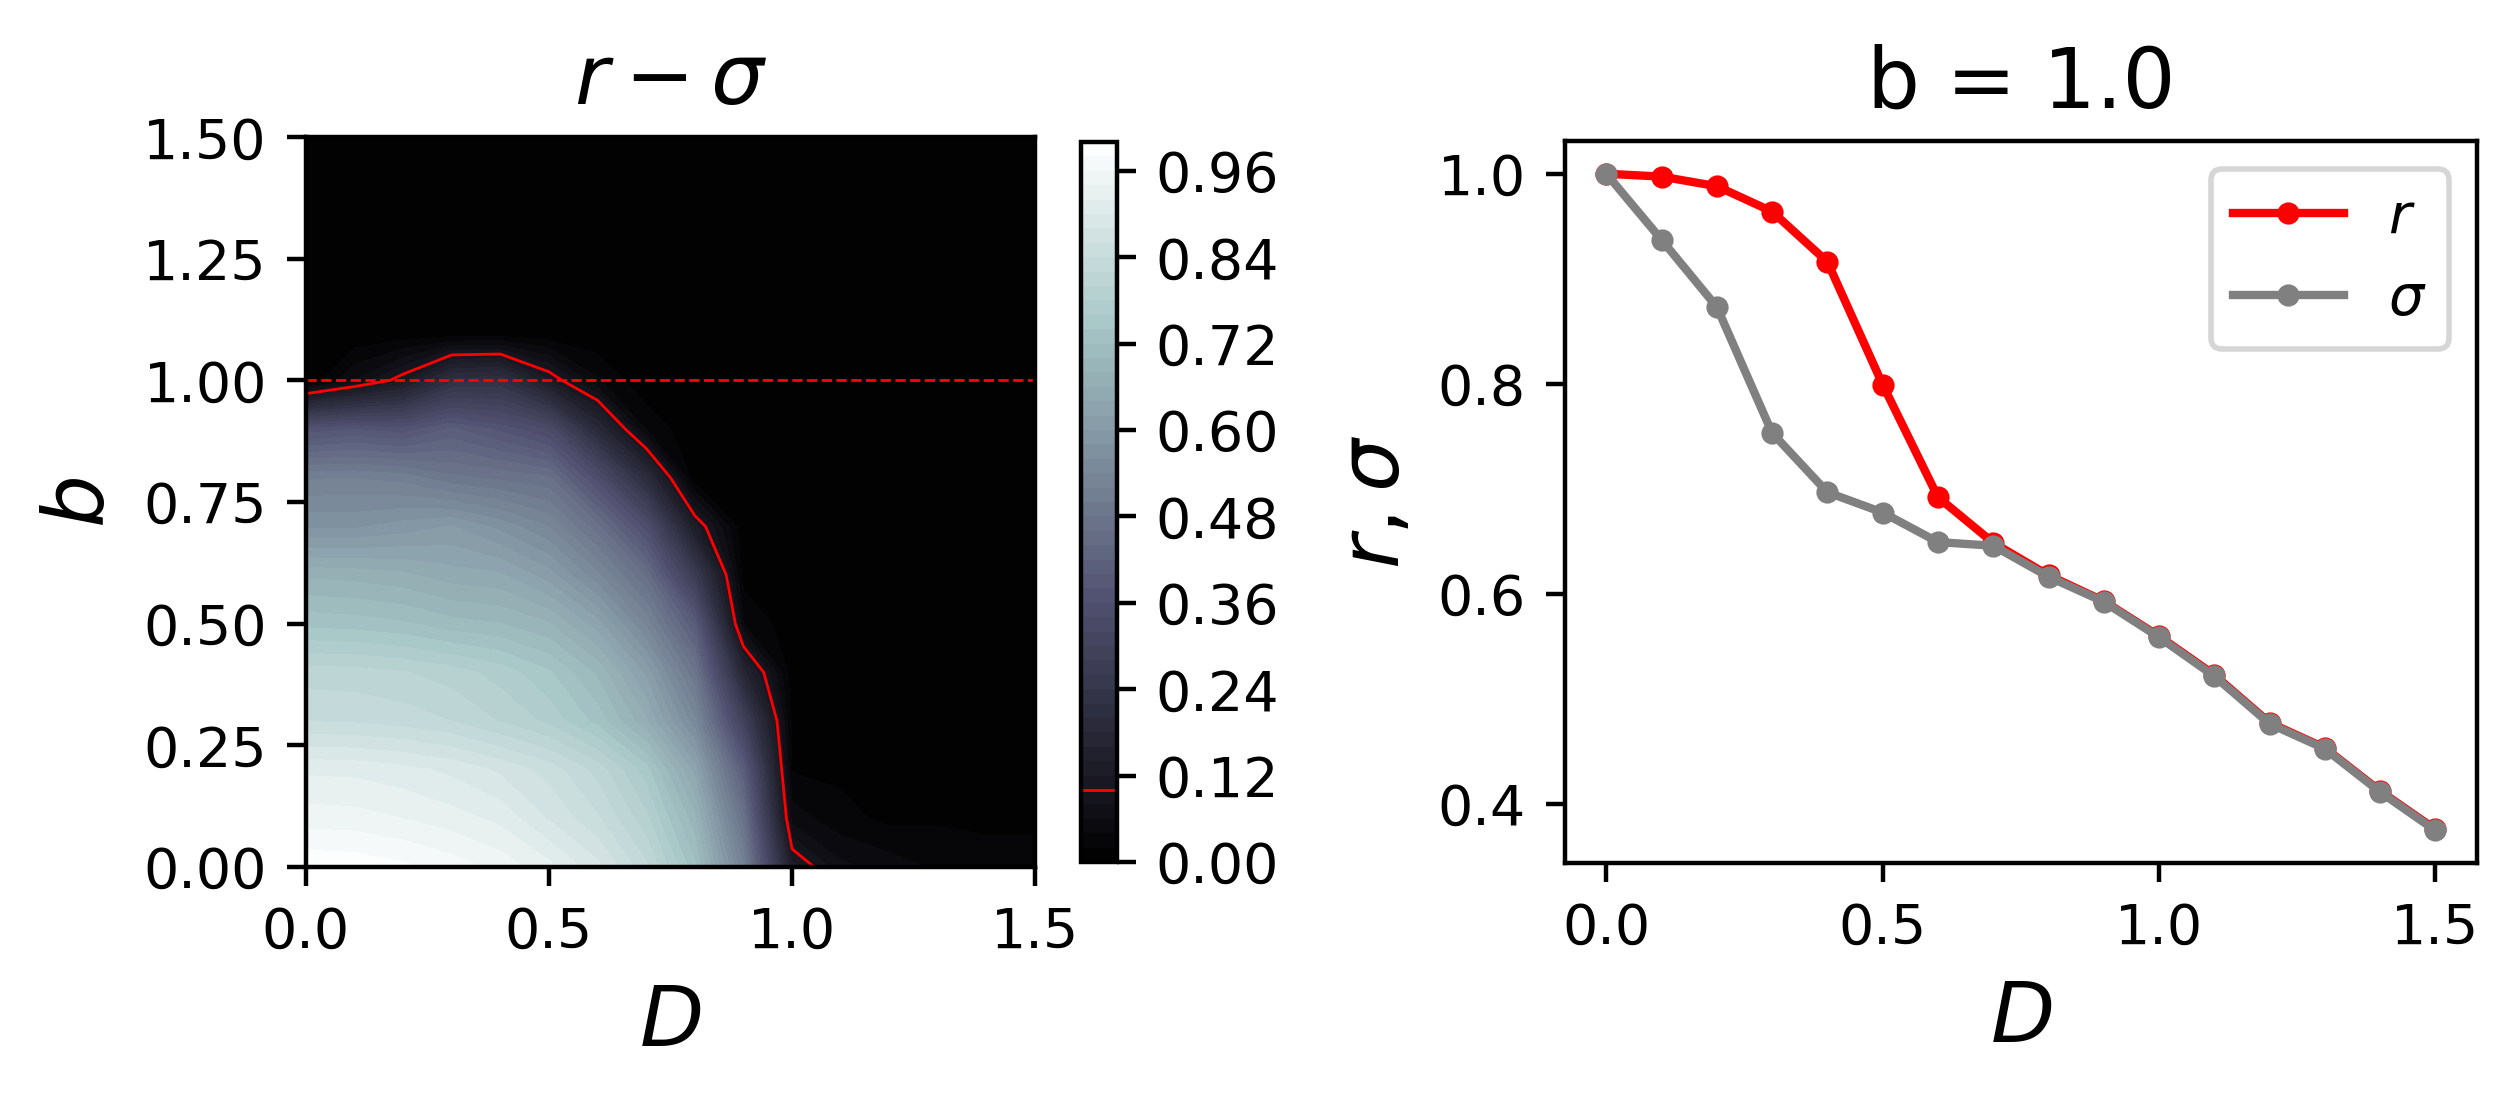

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,width_ratios=[1,1],dpi=400)
plt.sca(ax1)
b_idx = 10
Z = np.abs(D_sigmaij-D_r_meanij).T
CS = plt.contourf(DD, BB, Z,50, cmap=plt.cm.bone)

CS2 = plt.contour(CS, levels=CS.levels[5:6],linewidths=0.5, colors='r')
cbar = plt.colorbar(CS,shrink=0.4)
plt.gca().set_aspect('1')
cbar.add_lines(CS2)
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$b$',fontsize=15)
plt.title(r'$r-\sigma$',fontsize=15)

plt.axhline(bs[b_idx],color='red',lw=0.5,ls='--')

plt.sca(ax2)

plt.plot(Ds,D_r_meanij[:,b_idx],'.-',color='red',label =r'$r$')
plt.plot(Ds,D_sigmaij[:,b_idx],'.-',color='gray',label =r'$\sigma$')
plt.gca().set_aspect('1.9')

plt.legend()
plt.xlabel(r'$D$',fontsize=15)
plt.ylabel(r'$r,\sigma$',fontsize=15)
plt.title(f'b = {bs[b_idx]}',fontsize=15)

plt.tight_layout()
plt.show()